In [1]:
import tensorflow as tf
import tensorflow.keras.layers
import tensorflow.keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objs as go
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
AUTOTUNE = tf.data.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')
import os
init = tf.keras.initializers.RandomNormal(stddev=0.02)
import zipfile
from tensorflow.keras.layers import Input, Concatenate, Conv2D, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import ReLU,Conv2DTranspose, Dropout
from six.moves import urllib
import tarfile
import pathlib
from tensorflow import keras
import sys
from tensorflow.keras import optimizers

In [2]:
!mkdir -p 'data'
data_dir = 'data/'

data_url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz'
filename = data_url.split('/')[-1]
filepath = data_dir + data_url.split('/')[-1]

if not os.path.exists(filepath):
  def progress(count, block_size, total_size):
    sys.stdout.write('\r>> Downloading %s %.1f%%' % \
        (filename, float(count * block_size) / total_size * 100))
    sys.stdout.flush()
  filepath, _ = urllib.request.urlretrieve(data_url, filepath, progress)
  tarfile.open(filepath, 'r:gz').extractall(data_dir)

>> Downloading 17flowers.tgz 100.0%

In [3]:
img_dir = data_dir + 'jpg/'
root_path = pathlib.Path(img_dir)
data = keras.utils.image_dataset_from_directory(
    directory=root_path,
    label_mode=None,
    batch_size=32,
    image_size=(256,256))

Found 1360 files belonging to 1 classes.


In [4]:
list_train = tf.data.Dataset.list_files(data_dir + 'jpg/*.jpg', shuffle=True)

In [5]:
print(tf.data.experimental.cardinality(list_train).numpy())

1360


In [6]:
list_train = list_train.skip(3)
print(tf.data.experimental.cardinality(list_train).numpy())

1357


In [7]:
def decode_img(img):
    img = tf.io.read_file(img)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256,512))

    input_img, target_img = img[:,:256], img[:,256:]
    input_img, target_img = normalize(input_img, target_img)
    input_img = tf.cast(input_img, tf.float32)
    target_img = tf.cast(target_img, tf.float32)
    return target_img, input_img


def normalize(input_img, target_img):
    input_img = input_img / 127.5 - 1
    target_img = target_img / 127.5 - 1
    return input_img, target_img

def denormalize(img):
    img = (img + 1) * 127.5
    return img

In [8]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256, 256, 3])

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_img, target_img):
    target_img, input_img = resize(input_img, target_img, 286, 286)
    target_img, input_img = random_crop(input_img, target_img)

    if tf.random.uniform(()) > 0.5:
        target_img = tf.image.flip_left_right(target_img)
        input_img = tf.image.flip_left_right(input_img)

    return input_img, target_img

In [9]:
train_ds = list_train.map(decode_img, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(random_jitter, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(1)
train_ds = train_ds.prefetch(AUTOTUNE)
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>

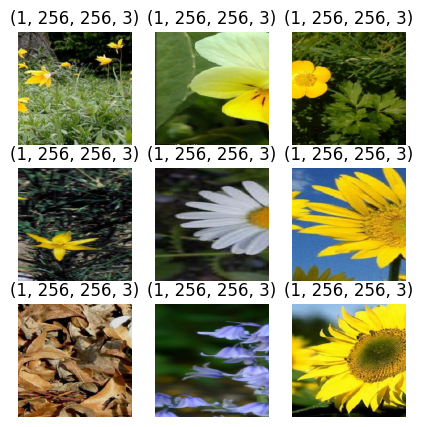

In [10]:
plt.figure(figsize=(5, 5))
counter = 0
for sat, map_ in train_ds:
    plt.subplot(3, 3, counter + 1)
    plt.imshow(np.squeeze(sat) * 0.5 + 0.5)
    plt.title(sat.shape)
    plt.axis("off")
    counter+=1
    if counter==9: break

In [11]:
def Discriminator(image_shape):
    image = Input(shape=image_shape)
    target = Input(shape=image_shape)
    concat = Concatenate()([image, target])
    x = Conv2D(64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(concat)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(512, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, kernel_size=(4,4), padding='same', kernel_initializer=init)(x)
    x = Activation('sigmoid')(x)
    model = Model([image, target], x)
    return model

In [12]:
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
Discriminator = Discriminator((256,256,3))
Discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 256, 256, 6)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         6208      ['concatenate[0][0]']     

In [13]:
def encoder(inputs, filters, batch_norm=True):
    x = Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    if batch_norm:
        x = BatchNormalization()(x, training=True)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def decoder(inputs, skip, filters, dropout=True):
    x = Conv2DTranspose(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputs)
    x = BatchNormalization()(x, training=True)
    if dropout:
        x = Dropout(0.5)(x, training=True)
    x = Concatenate()([x, skip])
    x = Activation('relu')(x)
    return x

In [14]:
def Generator(input_shape):
    inputs = Input(shape=input_shape)

    x1 = encoder(inputs, 64, batch_norm=False)
    x2 = encoder(x1, 128)
    x3 = encoder(x2, 256)
    x4 = encoder(x3, 512)
    x5 = encoder(x4, 512)
    x6 = encoder(x5, 512)
    x7 = encoder(x6, 512)

    x = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x7)
    x = ReLU()(x)

    y1 = decoder(x, x7, 512)
    y2 = decoder(y1, x6, 512)
    y3 = decoder(y2, x5, 512)
    y4 = decoder(y3, x4, 512, dropout=False)
    y5 = decoder(y4, x3, 256, dropout=False)
    y6 = decoder(y5, x2, 128, dropout=False)
    y7 = decoder(y6, x1, 64, dropout=False)

    x_new = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(y7)
    x_new = tf.keras.activations.tanh(x_new)

    model = Model(inputs, x_new)
    return model

In [15]:

Generator = Generator((256,256,3))
Generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 128, 128, 64)         3136      ['input_3[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_5[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 64, 128)          131200    ['leaky_re_lu_4[0][0]']       
                                                                                            

In [16]:

generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)


In [17]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
mae = tf.keras.losses.MeanAbsoluteError()

In [18]:
def Generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_fn(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = mae(target, gen_output)
    gen_loss = gan_loss + (100 * l1_loss)
    return gen_loss

In [19]:
def Discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_fn(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_fn(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [20]:
@tf.function()
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = Generator(input_img, training=True)
        disc_real = Discriminator([input_img, target_img], training=True)
        disc_generated = Discriminator([input_img, generated], training=True)
        gen_total_loss = Generator_loss(disc_generated, generated, target_img)
        Disc_loss = Discriminator_loss(disc_real, disc_generated)
    generator_gradients = gen_tape.gradient(gen_total_loss, Generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, Generator.trainable_variables))
    discriminator_gradients = disc_tape.gradient(Disc_loss, Discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, Discriminator.trainable_variables))

    return gen_total_loss, Disc_loss

In [21]:
generator_loss = []
discriminator_loss = []

for epoch in range(36):
    for sat_img, map_img in train_ds.take(2000):
        gen_loss, disc_loss = train_step(sat_img, map_img)
        generator_loss.append(gen_loss), discriminator_loss.append(disc_loss)

    print(f"Epochs:{epoch} || Generator_Loss: {gen_loss:.3f} || Discriminator_Loss: {disc_loss:.3f}")

Epochs:0 || Generator_Loss: 49.845 || Discriminator_Loss: 0.140
Epochs:1 || Generator_Loss: 54.343 || Discriminator_Loss: 0.220
Epochs:2 || Generator_Loss: 30.823 || Discriminator_Loss: 2.066
Epochs:3 || Generator_Loss: 31.697 || Discriminator_Loss: 0.292
Epochs:4 || Generator_Loss: 41.218 || Discriminator_Loss: 1.296
Epochs:5 || Generator_Loss: 46.452 || Discriminator_Loss: 0.107
Epochs:6 || Generator_Loss: 26.544 || Discriminator_Loss: 2.226
Epochs:7 || Generator_Loss: 38.822 || Discriminator_Loss: 0.231
Epochs:8 || Generator_Loss: 40.882 || Discriminator_Loss: 1.467
Epochs:9 || Generator_Loss: 35.169 || Discriminator_Loss: 0.221
Epochs:10 || Generator_Loss: 47.797 || Discriminator_Loss: 0.079
Epochs:11 || Generator_Loss: 45.935 || Discriminator_Loss: 0.052
Epochs:12 || Generator_Loss: 37.174 || Discriminator_Loss: 0.149
Epochs:13 || Generator_Loss: 34.005 || Discriminator_Loss: 0.407
Epochs:14 || Generator_Loss: 31.684 || Discriminator_Loss: 0.257
Epochs:15 || Generator_Loss: 34.428

1/1 [==============================] - 0s 38ms/step


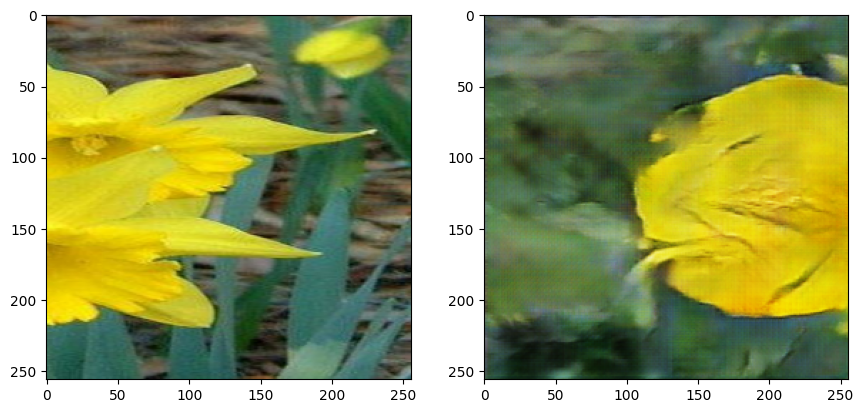

In [23]:
x, y = decode_img("/content/data/jpg/image_0003.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
#plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

1/1 [==============================] - 0s 33ms/step


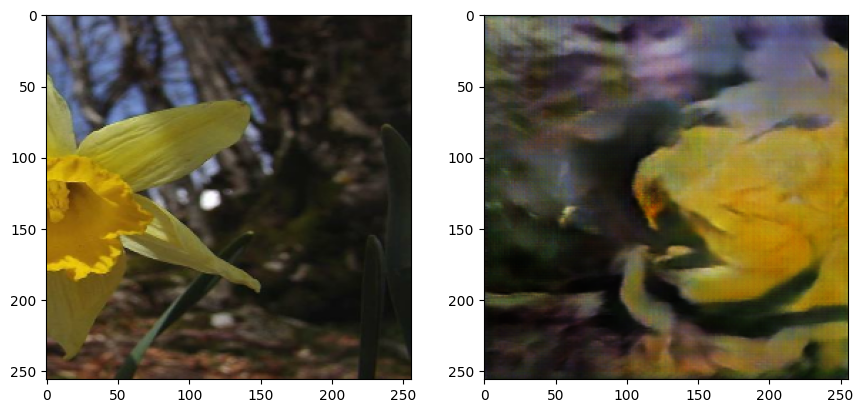

In [25]:
x, y = decode_img("/content/data/jpg/image_0002.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
#plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()

1/1 [==============================] - 0s 36ms/step


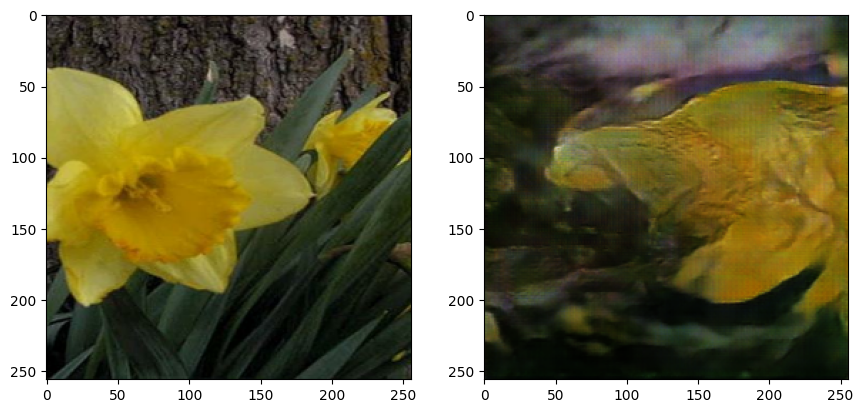

In [26]:
x, y = decode_img("/content/data/jpg/image_0001.jpg")
preds = Generator.predict(tf.expand_dims(x, axis=0))

plt.figure(figsize=(16,9))
plt.subplot(131), plt.imshow(denormalize(x).numpy().astype('uint8'))
#plt.subplot(132), plt.imshow(denormalize(y).numpy().astype('uint8'))
plt.subplot(132), plt.imshow(np.squeeze(denormalize(preds)).astype('uint8'))
plt.show()